In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os,gc,re,time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy,random
from collections import Counter
import warnings,unicodedata
warnings.simplefilter("ignore")


#setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available device: {device}')

Available device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# os.chdir('/content/drive/MyDrive/NLP/Machine Translation')
os.chdir('/content/drive/MyDrive/Colab Notebooks/MTranslation')

## Loading csv

In [4]:
train_csv_path,val_csv_path,test_csv_path = 'data/train.csv','data/val.csv','data/test.csv'
df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)
df_test = pd.read_csv(test_csv_path)

print(df_train.shape,df_val.shape,df_test.shape)

(29000, 2) (1014, 2) (1000, 2)


In [5]:
df_train.head()


,English,Ger
0,Two young White males are outside near many b...,Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [6]:
df_val.head()

,English,Ger
0,A group of men are loading cotton onto a truck,Eine Gruppe von Männern lädt Baumwolle auf ein...
1,A man sleeping in a green room on a couch.,Ein Mann schläft in einem grünen Raum auf eine...
2,A boy wearing headphones sits on a woman's sho...,Ein Junge mit Kopfhörern sitzt auf den Schulte...
3,Two men setting up a blue ice fishing hut on a...,Zwei Männer bauen eine blaue Eisfischerhütte a...
4,A balding man wearing a red life jacket is sit...,Ein Mann mit beginnender Glatze der eine rote...


In [7]:
df_test.head()

,English,Ger
0,A man in an orange hat starring at something.,Ein Mann mit einem orangefarbenen Hut der etw...
1,A Boston Terrier is running on lush green gras...,Ein Boston Terrier läuft über saftig-grünes Gr...
2,A girl in karate uniform breaking a stick with...,Ein Mädchen in einem Karateanzug bricht ein Br...
3,Five people wearing winter jackets and helmets...,Fünf Leute in Winterjacken und mit Helmen steh...
4,People are fixing the roof of a house.,Leute Reparieren das Dach eines Hauses.


## Checking null values and duplicates

In [8]:
df_train.isnull().sum()

English    0
Ger        0
dtype: int64

In [9]:
df_train[df_train.duplicated()]

,English,Ger
14214,A dog swims in the water.,Ein Hund schwimmt im Wasser.
16866,A dog runs through the woods.,Ein Hund rennt durch den Wald.
20148,A dog swimming with a stick in its mouth.,Ein Hund schwimmt mit einem Stock im Maul.


In [10]:
# we will drop duplicates
df_train = df_train.drop_duplicates()

In [11]:
# checking duplicates in validation data
df_val[df_val.duplicated()]

,English,Ger


In [12]:
# checking duplicates in test data
df_test[df_test.duplicated()]

,English,Ger


## Clean text - Preprocess Pipeline

In [13]:
from utils.utils import clean_eng_text,clean_ger_text

df_train["English"] = df_train["English"].apply(lambda x: clean_eng_text(x))
df_train["Ger"] = df_train["Ger"].apply(lambda x: clean_ger_text(x))

df_val["English"] = df_val["English"].apply(lambda x: clean_eng_text(x))
df_val["Ger"] = df_val["Ger"].apply(lambda x: clean_ger_text(x))

df_test["English"] = df_test["English"].apply(lambda x: clean_eng_text(x))
df_test["Ger"] = df_test["Ger"].apply(lambda x: clean_ger_text(x))


## Vocab generation

In [14]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 14.9 MB 5.4 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=0633e8809cee4df43489bc64d86e817369efcfa6c733420762a053471ddd7f5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pco7v7ot/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [15]:

from utils.vocab_generator import VocabGenerator

#creating corpus
corpus_eng = ' '.join(list(df_train['English'].values))
vocab_eng = VocabGenerator(corpus=corpus_eng, min_frequency=2,tokenizer_lang="english")

corpus_ger = ' '.join(list(df_train['Ger'].values))
vocab_ger = VocabGenerator(corpus=corpus_ger, min_frequency=2,tokenizer_lang="germen")

# printing some vocabs
print(vocab_eng.stoi["<UNK>"],vocab_eng.stoi["not"])

# printing some vocabs
print(vocab_ger.stoi["<UNK>"])

1 85
1


In [16]:
print(vocab_ger.stoi)

{'<UNK>': 1, '<PAD>': 0, '<SOS>': 2, '<EOS>': 3, 'Zwei': 4, 'junge': 5, 'weiße': 6, 'Männer': 7, 'sind': 8, 'im': 9, 'Freien': 10, 'in': 11, 'der': 12, 'Nähe': 13, 'vieler': 14, 'Büsche': 15, 'Mehrere': 16, 'mit': 17, 'Schutzhelmen': 18, 'bedienen': 19, 'ein': 20, 'Ein': 21, 'kleines': 22, 'Mädchen': 23, 'klettert': 24, 'Spielhaus': 25, 'aus': 26, 'Holz': 27, 'Mann': 28, 'einem': 29, 'blauen': 30, 'Hemd': 31, 'steht': 32, 'auf': 33, 'einer': 34, 'Leiter': 35, 'und': 36, 'putzt': 37, 'Fenster': 38, 'stehen': 39, 'am': 40, 'Herd': 41, 'bereiten': 42, 'Essen': 43, 'zu': 44, 'grün': 45, 'hält': 46, 'eine': 47, 'Gitarre': 48, 'während': 49, 'andere': 50, 'sein': 51, 'ansieht': 52, 'lächelt': 53, 'einen': 54, 'ausgestopften': 55, 'Löwen': 56, 'an': 57, 'schickes': 58, 'spricht': 59, 'dem': 60, 'Handy': 61, 'sie': 62, 'langsam': 63, 'die': 64, 'Straße': 65, 'Eine': 66, 'Frau': 67, 'großen': 68, 'Geldbörse': 69, 'geht': 70, 'Tor': 71, 'vorbei': 72, 'Jungen': 73, 'tanzen': 74, 'mitten': 75, 'Na

In [17]:
print(vocab_eng.stoi)

{'<UNK>': 1, '<PAD>': 0, '<SOS>': 2, '<EOS>': 3, 'two': 4, 'young': 5, 'white': 6, 'males': 7, 'are': 8, 'outside': 9, 'near': 10, 'many': 11, 'bushes': 12, 'several': 13, 'men': 14, 'in': 15, 'hard': 16, 'hats': 17, 'operating': 18, 'a': 19, 'giant': 20, 'pulley': 21, 'system': 22, 'little': 23, 'girl': 24, 'climbing': 25, 'into': 26, 'wooden': 27, 'playhouse': 28, 'man': 29, 'blue': 30, 'shirt': 31, 'is': 32, 'standing': 33, 'on': 34, 'ladder': 35, 'cleaning': 36, 'window': 37, 'at': 38, 'the': 39, 'stove': 40, 'preparing': 41, 'food': 42, 'green': 43, 'holds': 44, 'guitar': 45, 'while': 46, 'other': 47, 'observes': 48, 'his': 49, 'smiling': 50, 'stuffed': 51, 'lion': 52, 'trendy': 53, 'talking': 54, 'her': 55, 'cellphone': 56, 'gliding': 57, 'slowly': 58, 'down': 59, 'street': 60, 'woman': 61, 'with': 62, 'large': 63, 'purse': 64, 'walking': 65, 'by': 66, 'gate': 67, 'boys': 68, 'dancing': 69, 'poles': 70, 'middle': 71, 'of': 72, 'night': 73, 'ballet': 74, 'class': 75, 'five': 76, '

## Data Loader

In [18]:
# adjusting datashape to accomodate batch size
batch_size = 8

df_train = df_train.drop(df_train.tail((df_train.shape[0]%batch_size)).index)
df_val = df_val.drop(df_val.tail((df_val.shape[0]%batch_size)).index)
df_test = df_test.drop(df_test.tail((df_test.shape[0]%batch_size)).index)

print(df_train.shape,df_val.shape,df_test.shape)


(28992, 2) (1008, 2) (1000, 2)


In [19]:
from utils.data_loader import LoadTextDataset

# We already found in EDA section that maximum sequence length is 23 for english and 23 for germen.So including SOS and EOS token we will have a length of 25 each.

train_data = LoadTextDataset(df_train,vocab_ger,vocab_eng,input_seq_length=23,target_seq_length=23,padding=True)
val_data = LoadTextDataset(df_val,vocab_ger,vocab_eng,input_seq_length=23,target_seq_length=23,padding=True)
test_data = LoadTextDataset(df_test,vocab_ger,vocab_eng,input_seq_length=23,target_seq_length=23,padding=True)

In [20]:
print(f'Train data:')
for input_seq,target_seq in train_data:
    print(input_seq)
    print(target_seq)
    break

print('-'*100)
print('Validation data:')
for input_seq,target_seq in val_data:
    print(input_seq)
    print(target_seq)
    break

print('-'*100)
print('Test data:')
for input_seq,target_seq in test_data:
    print(input_seq)
    print(target_seq)
    break

Train data:
tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  3,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12,  3,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])
----------------------------------------------------------------------------------------------------
Validation data:
tensor([   2,   66,  125,   84,  395, 1848,    1,   33,   54,  991,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
tensor([   2,   19,  240,   72,   14,    8, 1048, 1250, 1502,   19,  669,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
----------------------------------------------------------------------------------------------------
Test data:
tensor([  2,  21,  28,  17,  29,  97, 200,  12, 174,   1,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
tensor([  2,  19,  29,  15, 200,

In [21]:
from torch.utils.data import DataLoader
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for data,target in train_loader:
    print(data.shape,target.shape)
    break

for data,target in valid_loader:
    print(data.shape,target.shape)
    break

torch.Size([8, 25]) torch.Size([8, 25])
torch.Size([8, 25]) torch.Size([8, 25])


# Model

In [22]:
from models.transformer import SeqtoSeqTransformer

# params
src_vocab_size = vocab_ger.__len__()
target_vocab_size = vocab_eng.__len__()
max_len_src = 25
max_len_target = 25

embedding_size = 512
no_of_heads = 8
no_of_encoders = 3
no_of_decoders = 3
drop_out = 0.2
no_fwd_expansion = 1024
pad_idx = vocab_ger.stoi["<PAD>"]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SeqtoSeqTransformer(src_vocab_size,target_vocab_size,max_len_src,max_len_target,embedding_size,
                 no_of_heads,no_of_encoders,no_of_decoders,pad_idx,
                 drop_out,no_fwd_expansion,device)


# weight initialization
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model.to(device)


SeqtoSeqTransformer(
  (src_word_embedding): EmbeddingLayer(
    (embedding): Embedding(7971, 512)
  )
  (src_positional_embedding): PositionalEncoding()
  (target_word_embedding): EmbeddingLayer(
    (embedding): Embedding(5918, 512)
  )
  (target_positional_embedding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2)

In [23]:



def predict_text(text,vocab_ger,vocab_eng,input_max_seq_length=23,target_max_seq_length=23):
    """
    function to predict the input text. It will translates the input german text to english
    Args:
        vocab_ger: german vocabulary
        vocab_eng: english vocabulary
        input_max_seq_length: maximum length of input sequence (Excluding EOS and SOS toekens)
        target_max_seq_length: maximum length of target sequence (Excluding EOS and SOS toekens)
    Returns: 
        predicted sentance
    """
    text = clean_ger_text(text)
    # generate integers
    tokens = vocab_ger.generate_numeric_tokens(text)
    # add <sos> and <eos>
    tokens = vocab_ger.add_eos_sos(tokens)
    # padd
    tokens = vocab_ger.pad_sequence(tokens,max_seq_length=input_max_seq_length)
    ger_tensor = torch.tensor(tokens).unsqueeze(0)
    # move input tensor to device
    ger_tensor = ger_tensor.to(device)
    
    with torch.no_grad():
        encoder_out = model.encoder(ger_tensor)

    # label tensor. we will begin with <SOS>
    outputs = [vocab_eng.stoi["<SOS>"]]
    predicted_sentence = []

    for i in range(target_max_seq_length+2):  #1 for each sos and eos
        
        output_tok = torch.LongTensor(outputs).unsqueeze(0).to(device)
        # output_tok = torch.LongTensor([outputs[-1]]).to(device)
        with torch.no_grad():
            
            out = model.decode(output_tok,encoder_out) 
            out = model.fc(out)
        
        # finding the token integer
        out = out[:,-1,:]
        out = F.softmax(out)
        
        predicted_word_int = out.argmax(1).item()
        outputs.append(predicted_word_int)
        
        # if end of senetence break
        if predicted_word_int == vocab_eng.stoi["<EOS>"]:
             break
    
    # print(outputs)
    predicted_sentence = [vocab_eng.itos[word_int] for word_int in outputs]
    predicted_sentence = predicted_sentence[1:]
    return ' '.join(predicted_sentence)



text = "Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund."
label_text = "Five people wearing winter jackets and helmets stand in the snow  with snowmobiles in the background."
model.eval()
pred = predict_text(text,vocab_ger,vocab_eng)
print(text)
print(pred)

Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
mounted memorial sunflower farmer sunflower farmer sunflower onlooking sunflower onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking onlooking


In [ ]:
import json
#creates folder to save log and models
save_folder = 'results/transformers'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)


with open(os.path.join(save_folder,'vocab_eng.json'), 'w') as fp:
    json.dump(vocab_eng.stoi, fp)

with open(os.path.join(save_folder,'vocab_ger.json'),'w') as fp:
    json.dump(vocab_ger.stoi, fp)


## Train

In [ ]:
from utils.utils import format_time
import pickle

epochs = 6

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = vocab_ger.stoi['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
save_folder = 'results/transformers'


valid_loss_min = np.Inf
start_time = time.time()
stats = []
for epoch in range(epochs):
     print(' ')
     print(f'=====Epoch {epoch + 1}=====')

     print('Sample prediction:')
     model.eval()

     text = "Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund."
     label_text = "Five people wearing winter jackets and helmets stand in the snow  with snowmobiles in the background."

     pred = predict_text(text,vocab_ger,vocab_eng)
     print(f'Actual input text: {text}')
     print(f'Actual output text: {label_text}')
     print('')
     print(f'predicted text: {pred}')
     print('')
     print('')
   
     #===============================
     #   Training
     #===============================

     print('Training....')
     t0 = time.time()
     train_loss = 0.0
     model.train(True)
     for inputs,targets in train_loader:
         inputs, targets = inputs.to(device), targets.to(device)
         
         # forward pass
         outputs = model(inputs,targets[:,:-1])  # outputs -> [seq_len,batch_size, target_vocab_size], targets-> [seq_len,batch_size]
         #compute loss
         # adjusting shapes
         outputs = outputs.reshape(-1, outputs.shape[2])
         
         targets = targets[:,1:].reshape(-1)
         
         # setting gradents to zero
         optimizer.zero_grad()
         loss = criterion(outputs,targets)
         
         train_loss += loss.item()
        
         # calculate gradients
         loss.backward()
         # Clip the gradient value is it exceeds > 1
         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
         # Update the weights values using the gradients we calculated using bp 
         optimizer.step()
         
     
     # calculate avg loss
     avg_train_loss = train_loss/len(train_loader) 
     # calculates training time
     training_time = format_time(time.time() - t0)
     
     print("  Average training loss: {0:.2f}".format(avg_train_loss))
     print("  Training epoch took: {:}".format(training_time))
    

     # ===============================
     #    Validation
     # ===============================

     print("")
     print("Running Validation...")
     t0 = time.time()
     model.eval()
     val_loss = 0.0
     for inputs,targets in valid_loader:
         inputs, targets = inputs.to(device), targets.to(device)
         with torch.no_grad():
             outputs = model(inputs,targets[:,:-1])
         # adjusting shapes
         outputs = outputs.reshape(-1, outputs.shape[2])
         targets = targets[:,1:].reshape(-1)
         loss = criterion(outputs,targets)
         val_loss += loss.item()
         
     # average validation loss
     avg_validation_loss = val_loss/len(valid_loader) 
     # Measure how long the validation run took.
     validation_time = format_time(time.time() - t0)
    
     print("  Validation Loss: {0:.2f}".format(avg_validation_loss))
     print("  Validation took: {:}".format(validation_time))


      # Record all statistics from this epoch.
     stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_validation_loss
        }
                 )

     if avg_validation_loss <= valid_loss_min:
        torch.save(model.state_dict(), os.path.join(save_folder,'model_transformers.pt'))
        torch.save(optimizer.state_dict(),os.path.join(save_folder,f'transformer_optimizer.pt'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_validation_loss))
        valid_loss_min = avg_validation_loss
    
     with open(os.path.join(save_folder,f'stats_{epoch+1}.pkl'), 'wb') as f:
          pickle.dump(stats, f)
     print(50*'==')

 
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-start_time)))



 
=====Epoch 1=====
Sample prediction:
Actual input text: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
Actual output text: Five people wearing winter jackets and helmets stand in the snow  with snowmobiles in the background.

predicted text: native completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely completely


Training....
  Average training loss: 3.82
  Training epoch took: 0:11:05

Running Validation...
  Validation Loss: 2.78
  Validation took: 0:00:19
Validation loss decreased (inf --> 2.781624).  Saving model ...
 
=====Epoch 2=====
Sample prediction:
Actual input text: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
Actual output text: Five people wearing winter jackets and helmets stand i

|   epoch |   Training Loss |   Valid. Loss |
|--------:|----------------:|--------------:|
|       1 |         3.81568 |       2.78162 |
|       2 |         2.56942 |       2.16695 |
|       3 |         2.03158 |       1.92186 |
|       4 |         1.70538 |       1.80363 |
|       5 |         1.47701 |       1.74032 |
|       6 |         1.29855 |       1.71692 |


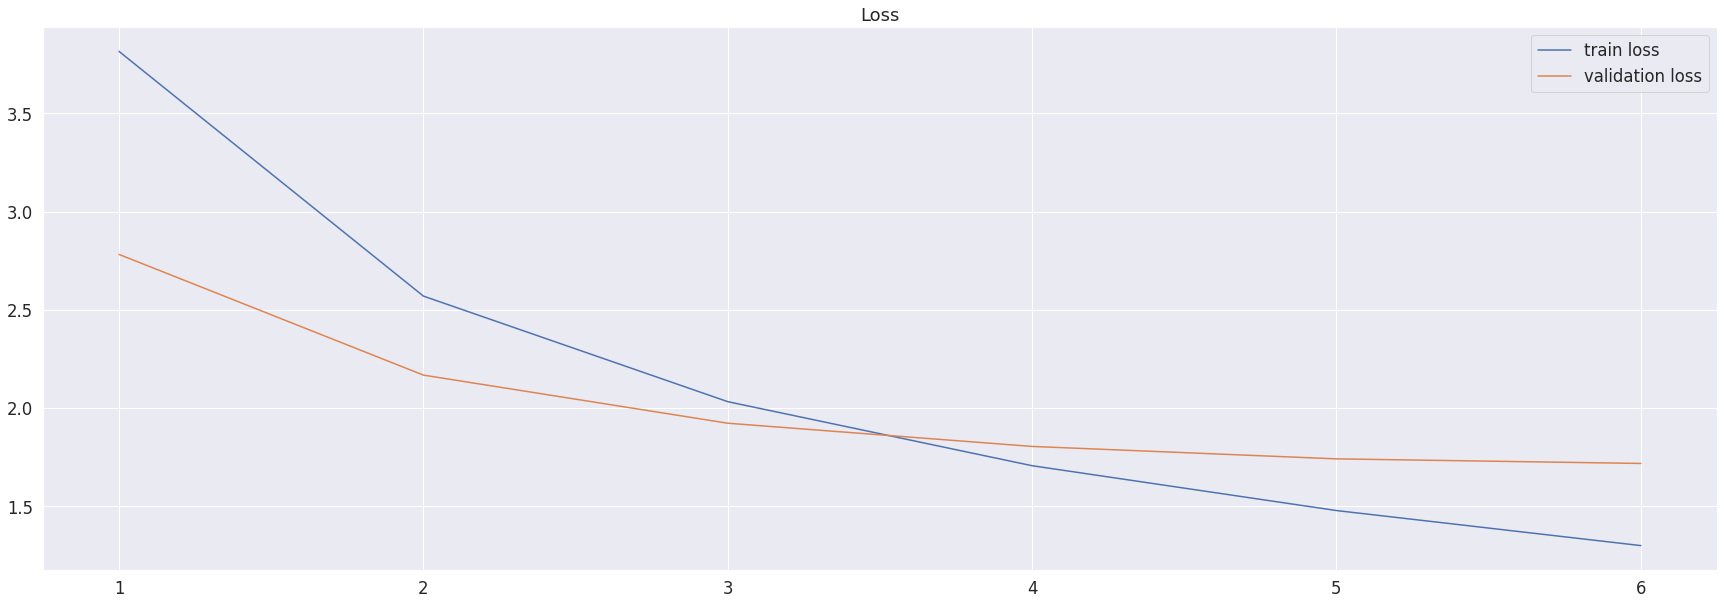

In [ ]:
 with open(os.path.join(save_folder,'stats_6.pkl'), 'rb') as f:
    stats = pickle.load(f)
    
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
print(df_stats.to_markdown())

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

fig,axes = plt.subplots(1,1,figsize=(30,10))
axes.plot(df_stats['Training Loss'],label="train loss")
axes.plot(df_stats['Valid. Loss'],label="validation loss")
axes.set_title('Loss')
axes.set_xticks([i+1 for i in range(epochs)])
axes.legend()
plt.show()

In [1]:
# from torchtext.data.metrics import bleu_score

# targets = []
# outputs = []
# df_test_ = df_test.head(100)
# for i,data in enumerate(df_test_.iterrows()):
#     input = data[1]['Ger']
#     target = data[1]['English']
#     target_clean = clean_eng_text(target)
#     pred = predict_text(input,vocab_ger,vocab_eng)
#     pred = pred.split()[:-1]
#     # pred_sent = ' '.join(pred)

#     targets.append([target_clean.split()])
#     outputs.append(pred)

# bleu_score(outputs, targets)

## More training

In [30]:
import pickle
#model
save_folder = 'results/transformers'
model_path= os.path.join(save_folder,'model_transformers.pt')
model.load_state_dict(torch.load(model_path))


# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_path = os.path.join(save_folder,'transformer_optimizer.pt')
optimizer.load_state_dict(torch.load(optimizer_path))


#loss
pad_idx = vocab_ger.stoi['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
valid_loss_min = 1.71692



#loading stats
with open(os.path.join(save_folder,'stats_6.pkl'), 'rb') as f:
    stats = pickle.load(f)


In [33]:

from utils.utils import format_time
import pickle

epochs = 13

start_time = time.time()
for epoch in range(6,epochs):
     print(' ')
     print(f'=====Epoch {epoch + 1}=====')

     print('Sample prediction:')
     model.eval()

     text = "Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund."
     label_text = "Five people wearing winter jackets and helmets stand in the snow  with snowmobiles in the background."

     pred = predict_text(text,vocab_ger,vocab_eng)
     print(f'Actual input text: {text}')
     print(f'Actual output text: {label_text}')
     print('')
     print(f'predicted text: {pred}')
     print('')
     print('')
   
     #===============================
     #   Training
     #===============================

     print('Training....')
     t0 = time.time()
     train_loss = 0.0
     model.train(True)
     for inputs,targets in train_loader:
         inputs, targets = inputs.to(device), targets.to(device)
         
         # forward pass
         outputs = model(inputs,targets[:,:-1])  # outputs -> [seq_len,batch_size, target_vocab_size], targets-> [seq_len,batch_size]
         #compute loss
         # adjusting shapes
         outputs = outputs.reshape(-1, outputs.shape[2])
         
         targets = targets[:,1:].reshape(-1)
         
         # setting gradents to zero
         optimizer.zero_grad()
         loss = criterion(outputs,targets)
         
         train_loss += loss.item()
        
         # calculate gradients
         loss.backward()
         # Clip the gradient value is it exceeds > 1
         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
         # Update the weights values using the gradients we calculated using bp 
         optimizer.step()
         
     
     # calculate avg loss
     avg_train_loss = train_loss/len(train_loader) 
     # calculates training time
     training_time = format_time(time.time() - t0)
     
     print("  Average training loss: {0:.2f}".format(avg_train_loss))
     print("  Training epoch took: {:}".format(training_time))
    

     # ===============================
     #    Validation
     # ===============================

     print("")
     print("Running Validation...")
     t0 = time.time()
     model.eval()
     val_loss = 0.0
     for inputs,targets in valid_loader:
         inputs, targets = inputs.to(device), targets.to(device)
         with torch.no_grad():
             outputs = model(inputs,targets[:,:-1])
         # adjusting shapes
         outputs = outputs.reshape(-1, outputs.shape[2])
         targets = targets[:,1:].reshape(-1)
         loss = criterion(outputs,targets)
         val_loss += loss.item()
         
     # average validation loss
     avg_validation_loss = val_loss/len(valid_loader) 
     # Measure how long the validation run took.
     validation_time = format_time(time.time() - t0)
    
     print("  Validation Loss: {0:.2f}".format(avg_validation_loss))
     print("  Validation took: {:}".format(validation_time))


      # Record all statistics from this epoch.
     stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_validation_loss
        }
                 )

     if avg_validation_loss <= valid_loss_min:
        torch.save(model.state_dict(), os.path.join(save_folder,'model_transformers_2.pt'))
        torch.save(optimizer.state_dict(),os.path.join(save_folder,f'transformer_optimizer_2.pt'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_validation_loss))
        valid_loss_min = avg_validation_loss
    
     with open(os.path.join(save_folder,f'stats_{epoch+1}.pkl'), 'wb') as f:
          pickle.dump(stats, f)
     print(50*'==')

 
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-start_time)))



 
=====Epoch 7=====
Sample prediction:
Actual input text: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
Actual output text: Five people wearing winter jackets and helmets stand in the snow  with snowmobiles in the background.

predicted text: five people in winter jackets and helmets stand in snow with snow in the background <EOS>


Training....
  Average training loss: 1.15
  Training epoch took: 0:11:43

Running Validation...
  Validation Loss: 1.74
  Validation took: 0:00:20
 
=====Epoch 8=====
Sample prediction:
Actual input text: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
Actual output text: Five people wearing winter jackets and helmets stand in the snow  with snowmobiles in the background.

predicted text: five people in winter jackets and helmets stand in snow with snow in the background <EOS>


Training....
  Average training loss: 1.03
  Training epoch took: 0:11:20

Running Valid

|   epoch |   Training Loss |   Valid. Loss |
|--------:|----------------:|--------------:|
|       1 |        3.81568  |       2.78162 |
|       2 |        2.56942  |       2.16695 |
|       3 |        2.03158  |       1.92186 |
|       4 |        1.70538  |       1.80363 |
|       5 |        1.47701  |       1.74032 |
|       6 |        1.29855  |       1.71692 |
|       7 |        1.15141  |       1.74451 |
|       8 |        1.02671  |       1.76739 |
|       9 |        0.917571 |       1.81207 |
|      10 |        0.819796 |       1.85811 |
|      11 |        0.735851 |       1.89445 |
|      12 |        0.659552 |       1.94858 |
|      13 |        0.593837 |       1.99759 |


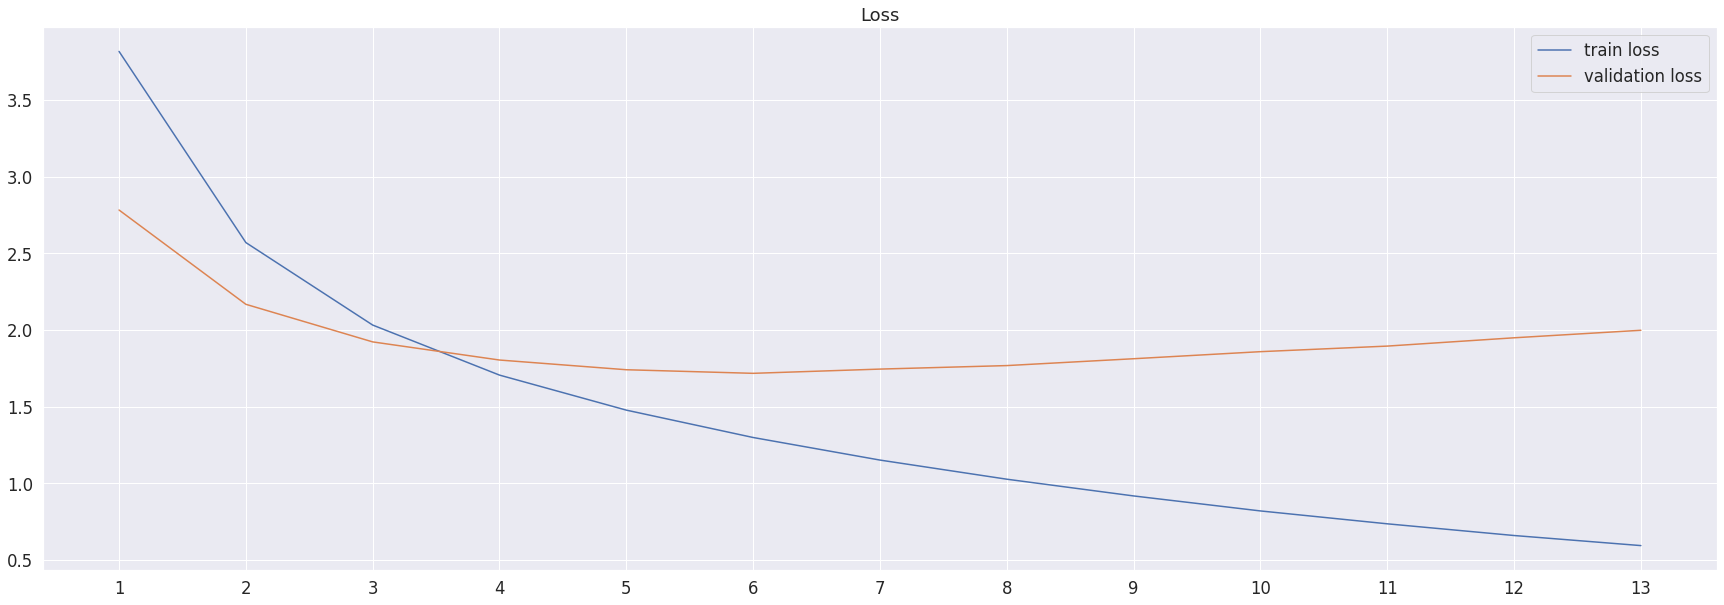

In [27]:
import pickle
#model
save_folder = 'results/transformers'

with open(os.path.join(save_folder,'stats_13.pkl'), 'rb') as f:
    stats = pickle.load(f)


epochs=13
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
print(df_stats.to_markdown())

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

fig,axes = plt.subplots(1,1,figsize=(30,10))
axes.plot(df_stats['Training Loss'],label="train loss")
axes.plot(df_stats['Valid. Loss'],label="validation loss")
axes.set_title('Loss')
axes.set_xticks([i+1 for i in range(epochs)])
axes.legend()
plt.show()

## Inference On Test data

In [31]:
model_path= os.path.join(save_folder,'model_transformers.pt')
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [32]:
from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.metrics import bleu_score

score_sum = 0
count = 0
targets = []
for i,data in enumerate(df_test.iterrows()):
   input = data[1]['Ger']
   target = data[1]['English']
   target_clean = clean_eng_text(target)
   targets.append([target_clean.split()])
   pred = predict_text(input,vocab_ger,vocab_eng)
   pred = pred.split()
   pred = ' '.join(pred[:-1])
   score = sentence_bleu([target_clean.split()],pred.split(),weights=(0.25, 0.25, 0.25, 0.25))
   score_sum += score

   int_ = random.randint(0,df_test.shape[0])
   if count < 10 and int_ < 100:
         print(f'Actual text: {input}')
         print(f'Actual output: {target}')
         print(f'Predicted text: {pred}')
         count += 1
         print(f'Bleu score: {score}')
         print('---'*50)


print(f'Average Bleu score: {score_sum/df_test.shape[0]}')


Actual text: Ein Mann mit einem orangefarbenen Hut der etwas anstarrt
Actual output: a man in an orange hat starring at something
Predicted text: a man in an orange hat holding something
Bleu score: 0.6240195441936914
------------------------------------------------------------------------------------------------------------------------------------------------------
Actual text: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund
Actual output: five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background
Predicted text: five people in winter jackets and helmets stand in snow with snow in the background
Bleu score: 0.45007028605391647
------------------------------------------------------------------------------------------------------------------------------------------------------
Actual text: Ein Mann schneidet Äste von Bäumen
Actual output: a man cutting branches of trees
Predicted text: a man cutting woo